# Estimation of tree height using GEDI dataset - Data explore


## Getting the dataset

For the here presented page donwolad the following dataset.

    
    cd ~/SE_data
    git pull
    rsync -hvrPt --ignore-existing ~/SE_data/* /media/sf_LVM_shared/my_SE_data
    cd  /media/sf_LVM_shared/my_SE_data/exercise
    pip install gdown
    gdown --id 1Y60EuLsfmTICTX-U_FxcE1odNAf04bd-
    tar -xvzf tree_height.tar.gz
    source ~/juplab_env/bin/activate
    ## allow to use system python packages
    sed 's/false/true/g' ~/juplab_env/pyvenv.cfg > ~/juplab_env/pyvenv_tmp.cfg ; 
    mv ~/juplab_env/pyvenv_tmp.cfg ~/juplab_env/pyvenv.cfg
    # install missing python libraries
    pip3 install numpy==1.18
    pip3 install ipywidgets --upgrade 
    pip3 install scikit-gstat
    # start the jupter-lab
    jupyter-lab Tree_Height_01DataExplore.ipynb


## GEDI features

The Global Ecosystem Dynamics Investigation (GEDI) mission aims to characterize ecosystem structure and dynamics to enable radically improved quantification of biomass. The GEDI instrument, attached to the International Space Station (ISS), collects data globally between 51.6° N and 51.6° S latitudes at the highest resolution and densest sampling of the 3-dimensional structure of the Earth.

GEDI's Level 2A Geolocated Elevation and Height Metrics Product (GEDI02_A) is primarily composed of Relative Height (RH) metrics of canopy height stored at different percentiles.

The GEDI02_A product is provided in HDF5 format and has a spatial resolution (average footprint) of 25 meters. The GEDI02_A data product contains 156 layers for each of the eight beams, including ground elevation, canopy top height, relative return energy metrics (e.g., canopy vertical structure), and many other interpreted products from the return waveforms. 


The [GEDI_Subsetter.py](https://git.earthdata.nasa.gov/projects/LPDUR/repos/gedi-subsetter/browse) allows the conversion of the HDF5 format in to txt files. 
During the conversion several parameters can be extracted. The full list can be found at https://lpdaac.usgs.gov/documents/982/gedi_l2a_dictionary_P003_v2.html , and a general description is stored at https://lpdaac.usgs.gov/documents/986/GEDI02_UserGuide_V2.pdf

In [1]:
from IPython.display import Image
import rasterio
from rasterio import *
from rasterio.plot import show
from rasterio.plot import show_hist
import geopandas
import pandas as pd
from matplotlib import pyplot
import skgstat as skg
import numpy as np
import seaborn as sns

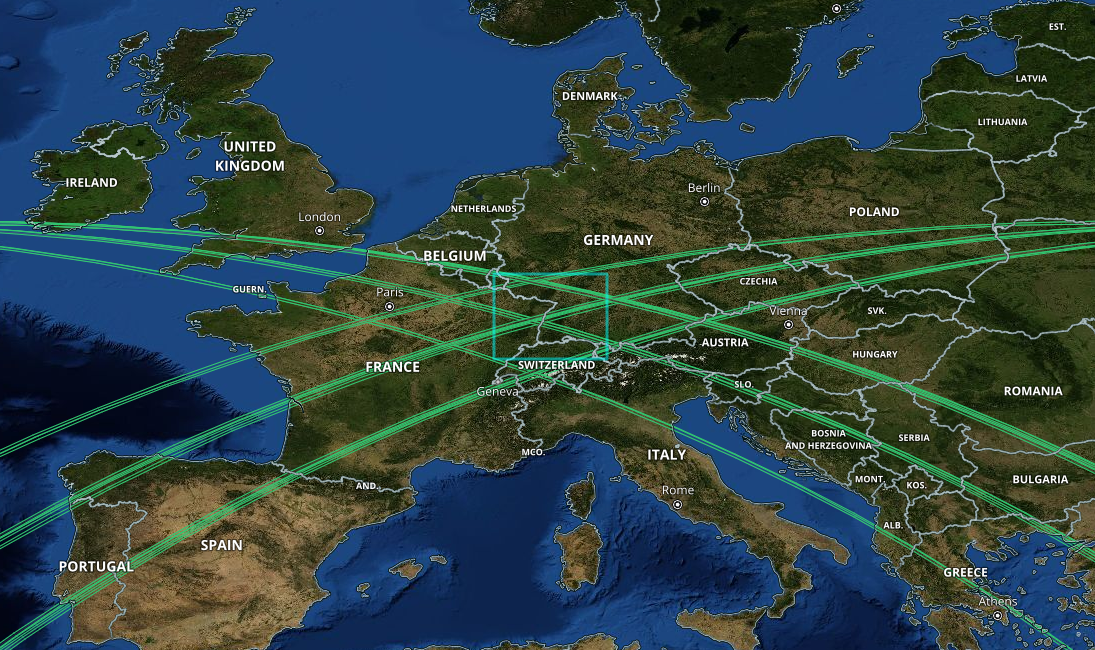

In [2]:
Image("../images/tree_height_path_map.png" , width = 500, height = 300)

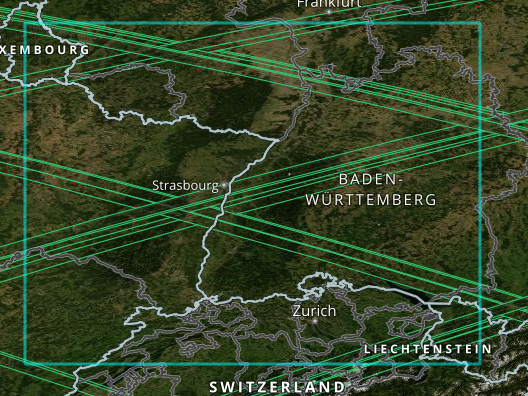

In [3]:
Image("../images/tree_height_study_area.png")

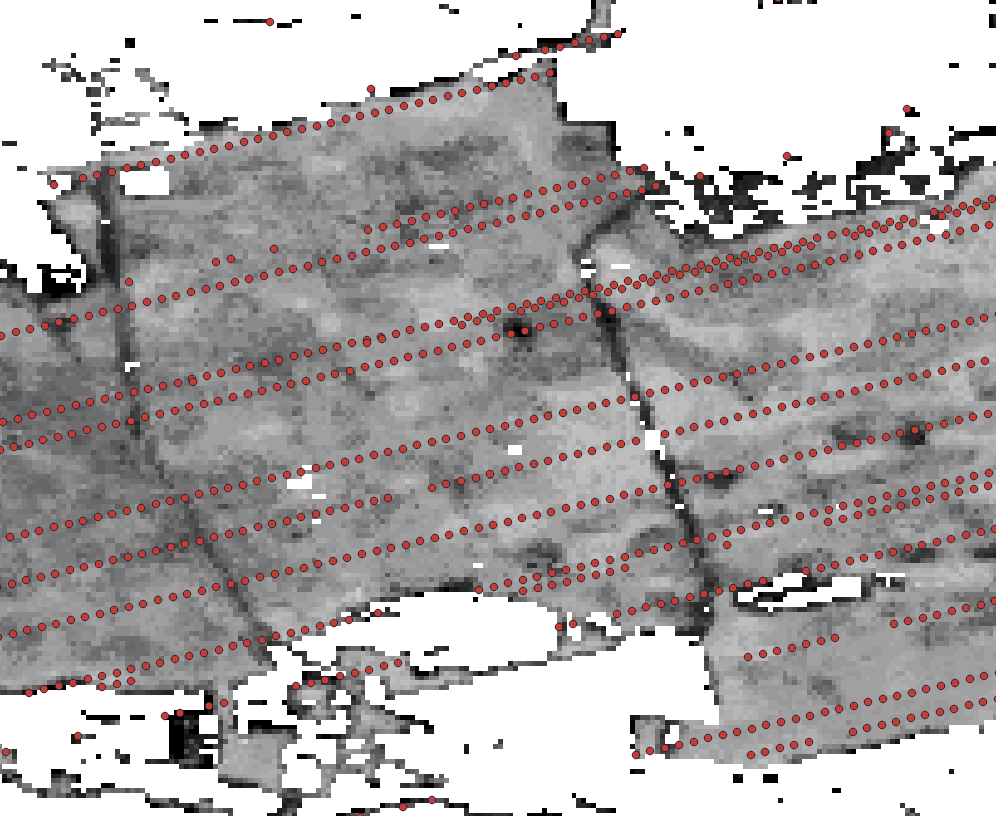

In [4]:
Image("../images/tree_height_study_area_selected.png" , width = 500, height = 300)

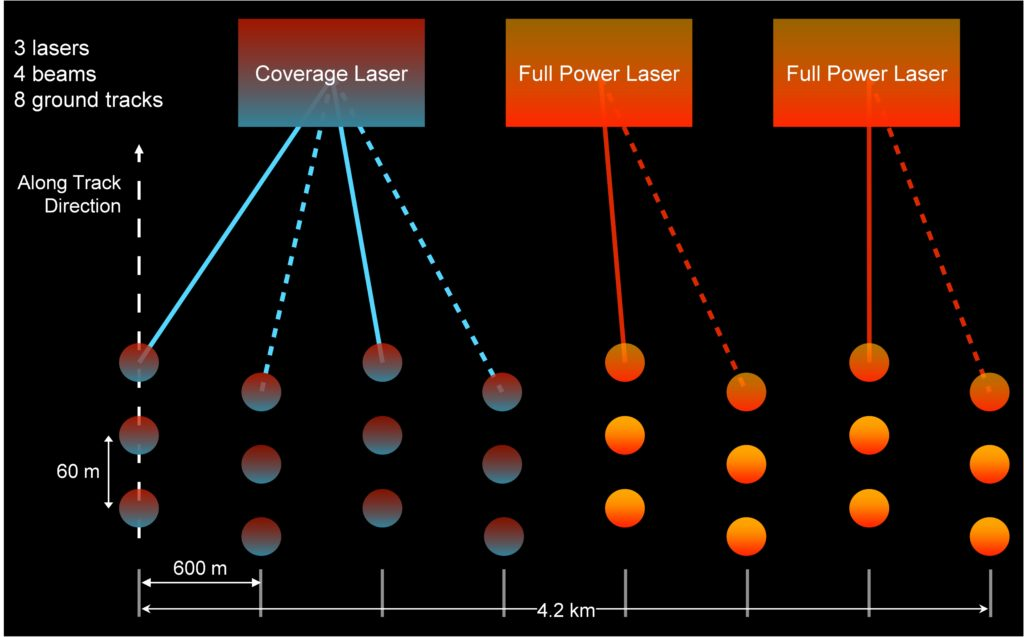

In [5]:
Image("../images/tree_hehght_beam.jpg" , width = 500, height = 300)

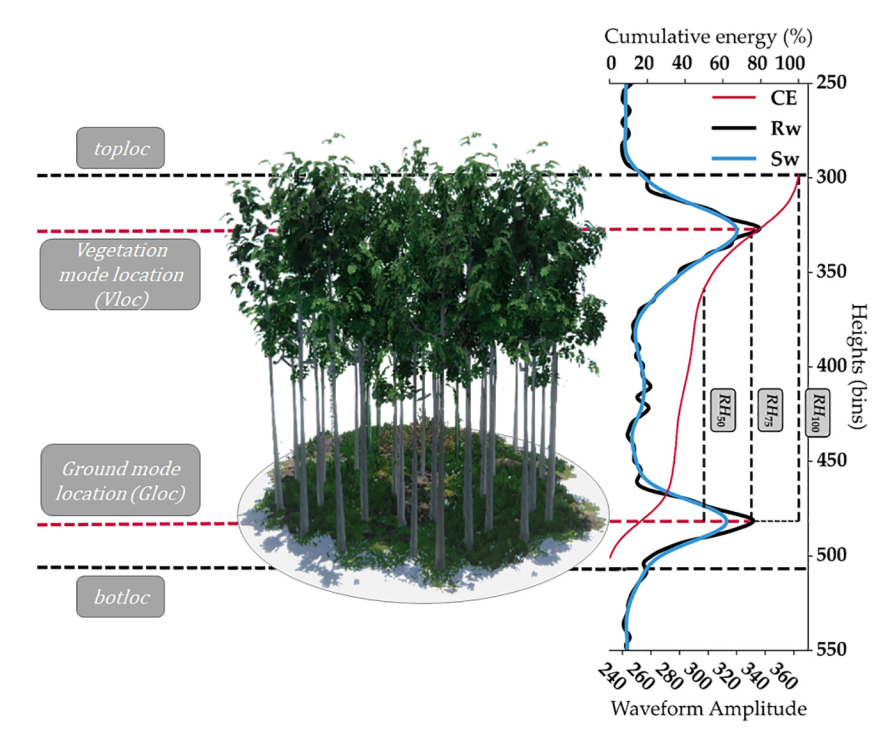

In [6]:
Image("../images/tree_height_pulse_distribution.png", width = 600, height = 300)

## Data presentation

### Available txt files

In [7]:
! ls tree_height/txt/*

tree_height/txt/eu_x_y_height_predictors_select.txt
tree_height/txt/eu_x_y_height_select.txt
tree_height/txt/eu_x_y_predictors_select.txt
tree_height/txt/eu_x_y_select.txt
tree_height/txt/eu_y_x_select_6algorithms_fullTable.txt


In [8]:
! wc -l tree_height/txt/*

  1267240 tree_height/txt/eu_x_y_height_predictors_select.txt
  1267240 tree_height/txt/eu_x_y_height_select.txt
  1267240 tree_height/txt/eu_x_y_predictors_select.txt
  1267239 tree_height/txt/eu_x_y_select.txt
  1267240 tree_height/txt/eu_y_x_select_6algorithms_fullTable.txt
  6336199 total


**File storing point location (longitude and latitude).**  
Such file can be used with "gdallocationinfo" to extract enviromental predictor at each point. 
The points have been already clean by removing all the points that falls in agricolture area, urban/built-up area, and water. In the immage below those areas are labeled in white.

In [9]:
! head tree_height/txt/eu_x_y_select.txt

6.050001 49.727499
6.0500017 49.922155
6.0500021 48.602377
6.0500089 48.151979
6.0500102 49.58841
6.0500143 48.608456
6.0500165 48.571401
6.0500189 49.921613
6.0500201 48.822645
6.0500238 49.847522


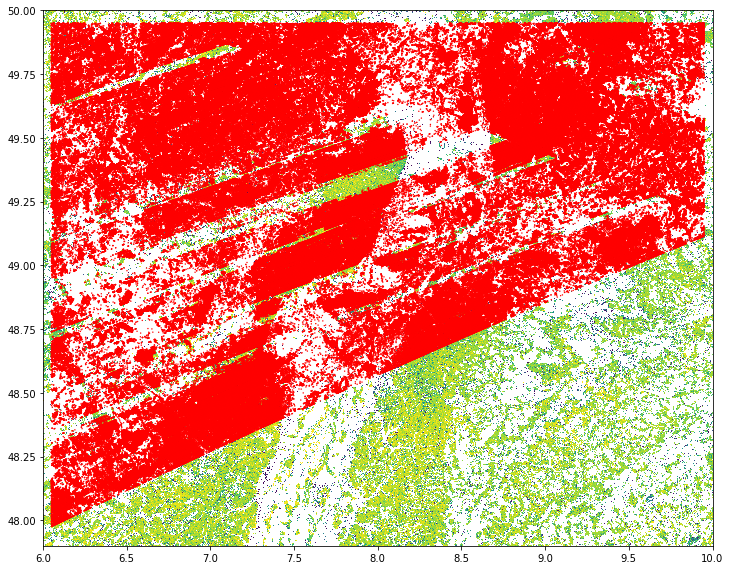

In [10]:
points = geopandas.read_file("tree_height/geodata_vector/eu_x_y_height_select.gpkg")
raster = rasterio.open("tree_height/geodata_raster/treecover.tif")
fig, ax = pyplot.subplots(figsize=(12, 12))
rasterio.plot.show(raster, ax=ax)
points.plot(ax=ax, facecolor='red', edgecolor='none', markersize=2)

**File storing tree hight (cm) obtained by 6 algorithms, with their associate quality flags.**
The quality flags can be used to refine and select the best tree height estimation and use it as tree height observation.

* a?_95: tree hight (cm) at 95 quintile, for each algorithm  
* min_rh_95: minimum value of tree hight (cm) ammong the 6 algorithms  
* max_rh_95: maximum value of tree hight (cm) ammong the 6 algorithms  
* BEAM: 1-4 coverage beam = lower power (worse) ; 5-8 power beam = higher power (better)  
* digital_elev: digital mdoel elevation  
* elev_low: elevation of center of lowest mode  
* qc_a?: quality_flag for six algorithms quality_flag = 1 (better); = 0 (worse)  
* se_a?: sensitivity for six algorithms sensitivity < 0.95 (worse);  sensitivity > 0.95  (better )  
* deg_fg: (degrade_flag) not-degraded 0 (better) ;  degraded > 0 (worse)  
* solar_ele: solar elevation. > 0 day (worse); < 0 night (better)  

In [11]:
height_6algorithms = pd.read_csv("tree_height/txt/eu_y_x_select_6algorithms_fullTable.txt", sep=" ",  index_col=False)
pd.set_option('display.max_columns',None)
height_6algorithms.head(6)

ID         X          Y  a1_95  a2_95  a3_95  a4_95  a5_95  a6_95  \
0   1  6.050001  49.727499   3139   3139   3139   3120   3139   3139   
1   2  6.050002  49.922155   1022   2303    970    872   5596   1524   
2   3  6.050002  48.602377    380   1336    332    362   1336   1340   
3   4  6.050009  48.151979   3153   3142   3142   3127   3138   3142   
4   5  6.050010  49.588410    666   4221    651     33   5611   2723   
5   6  6.050014  48.608456    787   1179   1187    761   1833   1833   

   min_rh_95  max_rh_95  BEAM  digital_elev    elev_low  qc_a1  qc_a2  qc_a3  \
0       3120       3139     5         410.0   383.72153      1      1      1   
1        872       5596     5         290.0  2374.14110      0      0      0   
2        332       1340     4         440.0   435.97781      1      1      1   
3       3127       3153     2         450.0   422.00537      1      1      1   
4         33       5611     8         370.0  2413.74830      0      0      0   
5        761       1833     3         420.0   415.51581      1      1      1   

   qc_a4  qc_a5  qc_a6  se_a1  se_a2  se_a3  se_a4  se_a5  se_a6  deg_fg  \
0      1      1      1  0.962  0.984  0.968  0.962  0.989  0.979       0   
1      0      0      0  0.948  0.990  0.960  0.948  0.994  0.980       0   
2      1      1      1  0.947  0.975  0.956  0.947  0.981  0.968       0   
3      1      1      1  0.930  0.970  0.943  0.930  0.978  0.962       0   
4      0      0      0  0.941  0.983  0.946  0.941  0.992  0.969       0   
5      1      1      1  0.952  0.979  0.961  0.952  0.986  0.975       0   

   solar_ele  
0       17.7  
1       43.7  
2        0.2  
3      -14.2  
4       22.1  
5        0.2

In [12]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
height_6algorithms.describe()

ID          X          Y      a1_95      a2_95      a3_95  \
count 1267239.00 1267239.00 1267239.00 1267239.00 1267239.00 1267239.00   
mean   633620.00       7.97      49.37    1807.40    2164.35    1885.92   
std    365820.53       1.10       0.47    1034.72    1107.12    1013.52   
min         1.00       6.05      47.98     115.00      82.00      37.00   
25%    316810.50       7.03      49.06     882.00    1474.00    1095.00   
50%    633620.00       7.84      49.51    1899.00    2240.00    1960.00   
75%    950429.50       8.98      49.73    2590.00    2817.00    2626.00   
max   1267239.00       9.95      49.95   14359.00   16070.00   14469.00   

           a4_95      a5_95      a6_95  min_rh_95  max_rh_95       BEAM  \
count 1267239.00 1267239.00 1267239.00 1267239.00 1267239.00 1267239.00   
mean     1587.37    2692.24    2129.05    1582.89    2703.53       4.75   
std      1058.24    1310.33    1045.41    1056.13    1322.65       2.29   
min         3.00      78.00      82.00       3.00     116.00       1.00   
25%       488.00    1921.00    1457.00     486.00    1928.00       3.00   
50%      1650.00    2706.00    2230.00    1644.00    2711.00       5.00   
75%      2472.00    3414.00    2812.00    2468.00    3416.00       7.00   
max     13620.00   18000.00   18299.00   13620.00   18299.00       8.00   

       digital_elev   elev_low      qc_a1      qc_a2      qc_a3      qc_a4  \
count    1267239.00 1267239.00 1267239.00 1267239.00 1267239.00 1267239.00   
mean         289.22     491.06       0.80       0.91       0.85       0.80   
std        10363.92     528.74       0.40       0.28       0.35       0.40   
min     -1000000.00     114.87       0.00       0.00       0.00       0.00   
25%          320.00     309.49       1.00       1.00       1.00       1.00   
50%          390.00     386.05       1.00       1.00       1.00       1.00   
75%          470.00     476.89       1.00       1.00       1.00       1.00   
max         1200.00    8566.18       1.00       1.00       1.00       1.00   

           qc_a5      qc_a6      se_a1      se_a2      se_a3      se_a4  \
count 1267239.00 1267239.00 1267239.00 1267239.00 1267239.00 1267239.00   
mean        0.92       0.90       0.93       0.97       0.95       0.93   
std         0.26       0.30       0.44       0.19       0.36       0.44   
min         0.00       0.00    -411.76    -178.46    -339.98    -411.76   
25%         1.00       1.00       0.92       0.97       0.94       0.92   
50%         1.00       1.00       0.95       0.98       0.96       0.95   
75%         1.00       1.00       0.97       0.99       0.97       0.97   
max         1.00       1.00     181.09      84.12     153.38     181.09   

           se_a5      se_a6     deg_fg  solar_ele  
count 1267239.00 1267239.00 1267239.00 1267239.00  
mean        0.98       0.96      12.46      -1.33  
std         0.14       0.25      25.89      30.75  
min      -124.62    -232.30       0.00     -63.60  
25%         0.98       0.96       0.00     -23.40  
50%         0.99       0.97       0.00      -4.90  
75%         0.99       0.98       0.00      23.30  
max        63.34     111.83      80.00      64.00

Count observation during the day (>0) and during the night (<0)

In [13]:
(height_6algorithms["solar_ele"] < 0).sum()   # night (better)

700460

In [14]:
(height_6algorithms["solar_ele"] > 0).sum()   # day (worse)

566779

Count uniq degraged (>0) or not-degraded (0) observation

In [15]:
height_6algorithms["deg_fg"].value_counts()

0     967716
70    139223
30     48378
5      44063
80     42052
50     16666
9       5815
71      1406
1       1368
35       481
39        71
Name: deg_fg, dtype: int64

In [16]:
height_6algorithms["solar_ele"].value_counts()

-35.10    17572
-35.20    11174
-20.60    10390
-16.80     9658
25.60      7223
          ...  
10.00         2
-0.40         1
-60.40        1
42.10         1
-32.40        1
Name: solar_ele, Length: 1101, dtype: int64

**File storing point location and tree height. The height is obtained as average of the 4 algorithms.**
Among the 6 algorithms we calculate minimum and maximum of heith values, then we calculate the mean excluding the minimum and the maximum. 

In [17]:
! head tree_height/txt/eu_x_y_height_select.txt  
! paste -d " "  tree_height/txt/eu_x_y_height_select.txt > 

ID X Y h
1 6.050001 49.727499 3139
2 6.0500017 49.922155 1454.75
3 6.0500021 48.602377 853.5
4 6.0500089 48.151979 3141
5 6.0500102 49.58841 2065.25
6 6.0500143 48.608456 1246.5
7 6.0500165 48.571401 2938.75
8 6.0500189 49.921613 3294.75
9 6.0500201 48.822645 1623.5
/bin/bash: -c: line 0: syntax error near unexpected token `newline'
/bin/bash: -c: line 0: ` paste -d " "  tree_height/txt/eu_x_y_height_select.txt >'


### Available geo raster files

In [18]:
! ls tree_height/geodata_raster

BLDFIE_WeigAver.tif    glad_ard_SVVI_med.tif
CECSOL_WeigAver.tif    glad_ard_SVVI_min.tif
CHELSA_bio18.tif       latitude.tif
CHELSA_bio4.tif        longitude.tif
convergence.tif        northness.tif
cti.tif		       ORCDRC_WeigAver.tif
dev-magnitude.tif      outlet_dist_dw_basin.tif
eastness.tif	       SBIO3_Isothermality_5_15cm.tif
elev.tif	       SBIO4_Temperature_Seasonality_5_15cm.tif
forestheight.tif       treecover.tif
glad_ard_SVVI_max.tif


The geo raster have been standarized in terms of extent and pixel resolution, using *gdal_translate* and *gdal_edit.py*

In [19]:
! gdalinfo tree_height/geodata_raster/glad_ard_SVVI_min.tif

Driver: GTiff/GeoTIFF
Files: tree_height/geodata_raster/glad_ard_SVVI_min.tif
Size is 16000, 8400
Coordinate System is:
GEOGCRS["WGS 84",
    DATUM["World Geodetic System 1984",
        ELLIPSOID["WGS 84",6378137,298.257223563,
            LENGTHUNIT["metre",1]]],
    PRIMEM["Greenwich",0,
        ANGLEUNIT["degree",0.0174532925199433]],
    CS[ellipsoidal,2],
        AXIS["geodetic latitude (Lat)",north,
            ORDER[1],
            ANGLEUNIT["degree",0.0174532925199433]],
        AXIS["geodetic longitude (Lon)",east,
            ORDER[2],
            ANGLEUNIT["degree",0.0174532925199433]],
    ID["EPSG",4326]]
Data axis to CRS axis mapping: 2,1
Origin = (6.000000000000000,50.000000000000000)
Pixel Size = (0.000250000000000,-0.000250000000000)
Metadata:
  AREA_OR_POINT=Area
  TIFFTAG_DATETIME=2022:04:25 04:05:10
  TIFFTAG_DOCUMENTNAME=/vast/palmer/home.grace/ga254/SE_data/exercise/tree_height/geodata_raster/glad_ard_SVVI_min.tif
  TIFFTAG_SOFTWARE=pktools 2.6.7.6 by Pieter Kempe

The urban building, agricolture land and water has been maskout using *pksetmask* and set as No-datga. In the following maps it is rappresented in white color. Point location has been moved accordingly. 

### Geo raster files description.

**Spectral Variability Vegetation Index obtained from the [GLAD ARD](https://glad.umd.edu/ard/glad-landsat-ard-tools) dataset.** 

* glad_ard_SVVI_min.tif: Spectral Variability Vegetation Index colculated using a 3 years temporal minimum composite. 
* glad_ard_SVVI_med.tif: Spectral Variability Vegetation Index colculated using a 3 years temporal median composite.
* glad_ard_SVVI_max.tif: Spectral Variability Vegetation Index colculated using a 3 years temporal maximum composite.

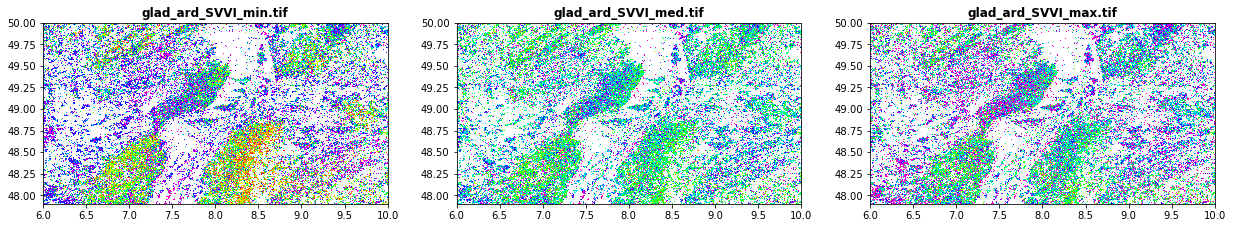

In [20]:
src1 = rasterio.open("tree_height/geodata_raster/glad_ard_SVVI_min.tif")
src2 = rasterio.open("tree_height/geodata_raster/glad_ard_SVVI_med.tif")
src3 = rasterio.open("tree_height/geodata_raster/glad_ard_SVVI_max.tif")
fig, (src1p,src2p,src3p) = pyplot.subplots(1,3, figsize=(21,7))
show(src1, ax=src1p, title='glad_ard_SVVI_min.tif' , vmin=-500, vmax=+500, cmap='gist_rainbow' )
show(src2, ax=src2p, title='glad_ard_SVVI_med.tif' , vmin=-500, vmax=+500, cmap='gist_rainbow' )
show(src3, ax=src3p, title='glad_ard_SVVI_max.tif' , vmin=-500, vmax=+500, cmap='gist_rainbow' )

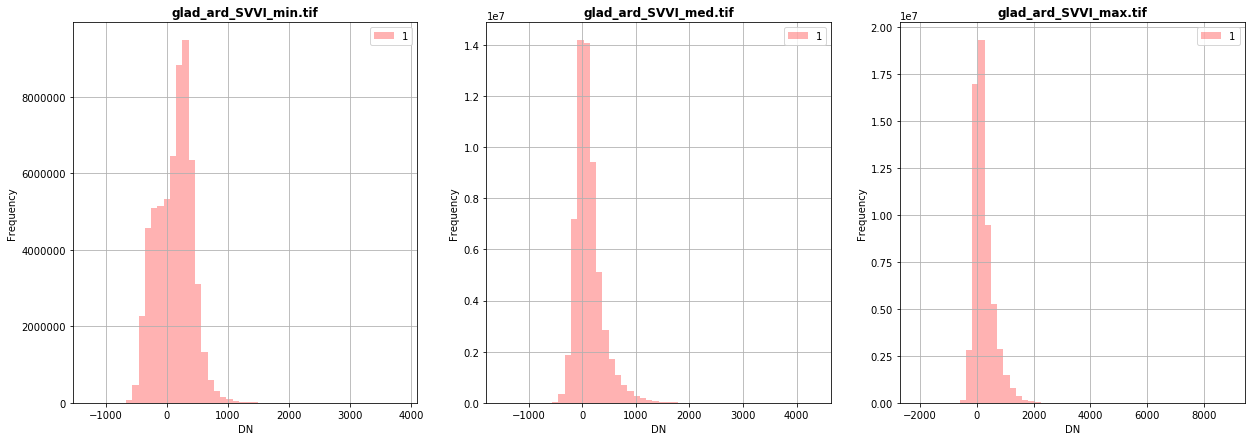

In [21]:
fig, (src1p,src2p,src3p) = pyplot.subplots(1,3, figsize=(21,7))
show_hist( src1, ax=src1p, bins=50, lw=0.0, stacked=False, alpha=0.3, histtype='stepfilled', title="glad_ard_SVVI_min.tif")
show_hist( src2, ax=src2p, bins=50, lw=0.0, stacked=False, alpha=0.3, histtype='stepfilled', title="glad_ard_SVVI_med.tif")
show_hist( src3, ax=src3p, bins=50, lw=0.0, stacked=False, alpha=0.3, histtype='stepfilled', title="glad_ard_SVVI_max.tif")

**Climate data obained from the [CHELSA](https://chelsa-climate.org/bioclim/) dataset.** 

* CHELSA_bio18.tif: mean monthly precipitation amount of the warmest quarter
* CHELSA_bio4.tif: temperature seasonality (standard deviation of the monthly mean temperatures)

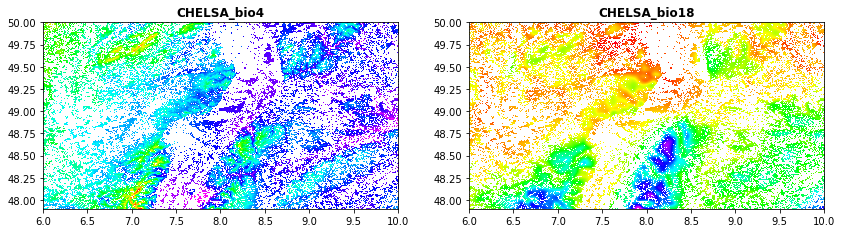

In [22]:
import rasterio
from rasterio.plot import show
src1 = rasterio.open("tree_height/geodata_raster/CHELSA_bio4.tif")
src2 = rasterio.open("tree_height/geodata_raster/CHELSA_bio18.tif")
fig, (src1p,src2p) = pyplot.subplots(1,2, figsize=(14,7))
show((src1), ax=src1p, title='CHELSA_bio4'  , cmap='gist_rainbow')
show((src2), ax=src2p, title='CHELSA_bio18' , cmap='gist_rainbow')

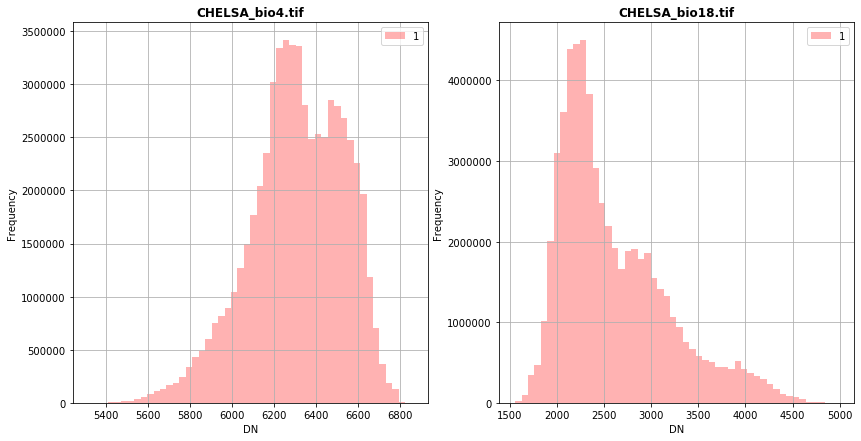

In [23]:
fig, (src1p,src2p) = pyplot.subplots(1,2, figsize=(14,7))
show_hist( src1, ax=src1p, bins=50, lw=0.0, stacked=False, alpha=0.3, histtype='stepfilled', title="CHELSA_bio4.tif")
show_hist( src2, ax=src2p, bins=50, lw=0.0, stacked=False, alpha=0.3, histtype='stepfilled', title="CHELSA_bio18.tif")

**Soil data obained from the [SOILGRID](https://soilgrids.org/)**

* BLDFIE_WeigAver.tif: Bulk density (fine earth) in kg / cubic-meter (weigheted average as function for the depth)
* CECSOL_WeigAver.tif: Cation exchange capacity of soil in cmolc/kg (weigheted average as function for the depth)
* ORCDRC_WeigAver.tif: Soil organic carbon content (fine earth fraction) in g per kg (weigheted average as function for the depth)

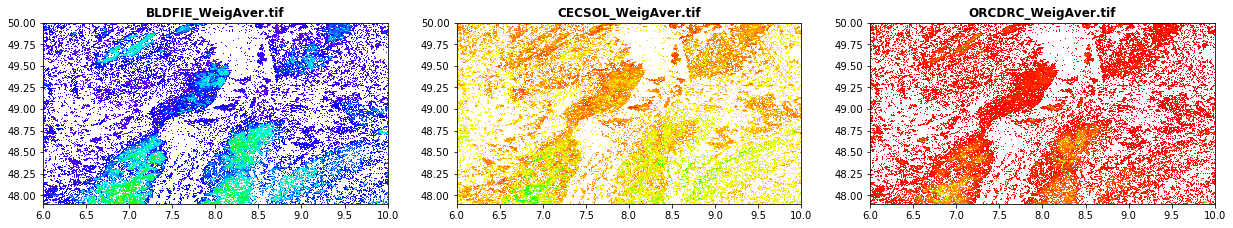

In [24]:
src1 = rasterio.open("tree_height/geodata_raster/BLDFIE_WeigAver.tif")
src2 = rasterio.open("tree_height/geodata_raster/CECSOL_WeigAver.tif")
src3 = rasterio.open("tree_height/geodata_raster/ORCDRC_WeigAver.tif")
fig, (src1p,src2p,src3p) = pyplot.subplots(1,3, figsize=(21,7))
show(src1, ax=src1p, title='BLDFIE_WeigAver.tif' , cmap='gist_rainbow')
show(src2, ax=src2p, title='CECSOL_WeigAver.tif' , cmap='gist_rainbow')
show(src3, ax=src3p, title='ORCDRC_WeigAver.tif' , cmap='gist_rainbow')

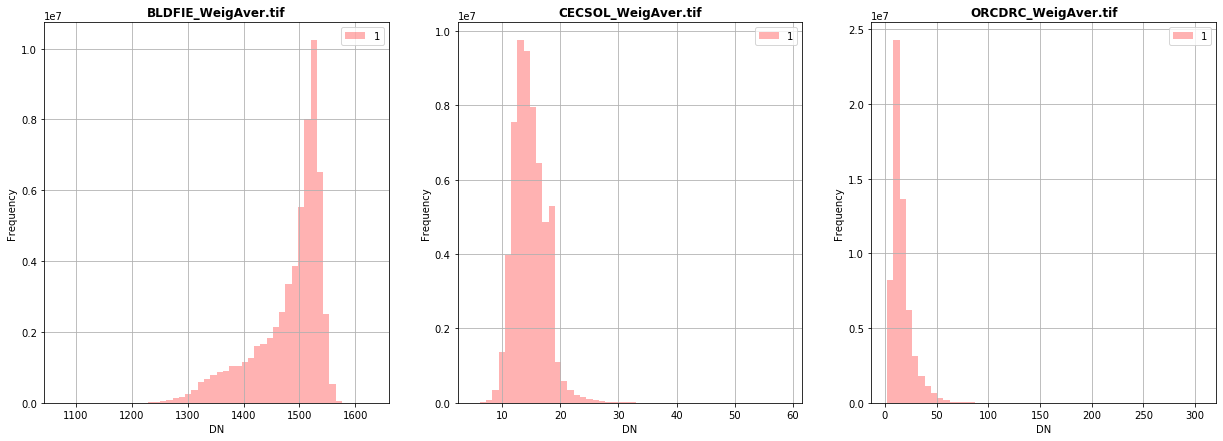

In [25]:
fig, (src1p,src2p,src3p) = pyplot.subplots(1,3, figsize=(21,7))
show_hist( src1, ax=src1p, bins=50, lw=0.0, stacked=False, alpha=0.3, histtype='stepfilled', title="BLDFIE_WeigAver.tif")
show_hist( src2, ax=src2p, bins=50, lw=0.0, stacked=False, alpha=0.3, histtype='stepfilled', title="CECSOL_WeigAver.tif")
show_hist( src3, ax=src3p, bins=50, lw=0.0, stacked=False, alpha=0.3, histtype='stepfilled', title="ORCDRC_WeigAver.tif")

**Geomorphological data obtained from [geomorpho90m](http://spatial-ecology.net/docs/build/html/GEODATA/geomorpho90m/geomorpho90m.html)**

* elev.tif: elevation
* convergence.tif: convergence 
* northness.tif: northness
* eastness.tif: eastness
* dev-magnitude.tif: Maximum multiscaledeviation

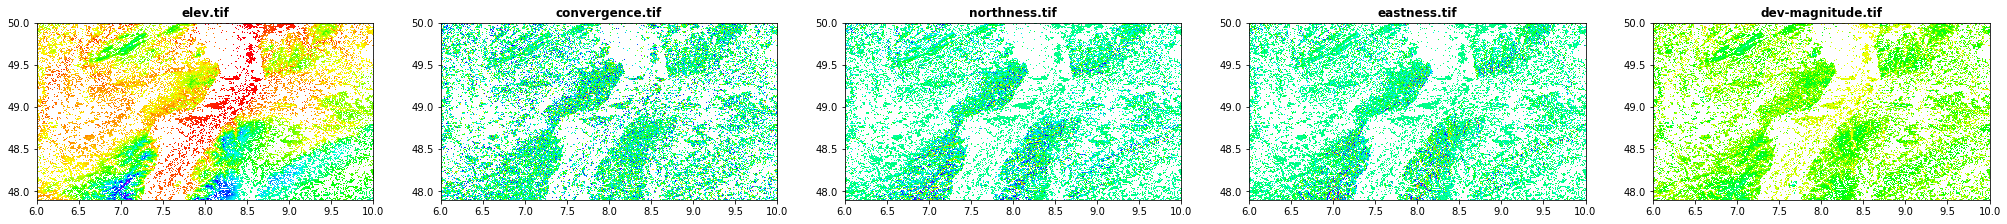

In [26]:
src1 = rasterio.open("tree_height/geodata_raster/elev.tif")
src2 = rasterio.open("tree_height/geodata_raster/convergence.tif")
src3 = rasterio.open("tree_height/geodata_raster/northness.tif")
src4 = rasterio.open("tree_height/geodata_raster/eastness.tif")
src5 = rasterio.open("tree_height/geodata_raster/dev-magnitude.tif")
fig, (src1p,src2p,src3p,src4p,src5p) = pyplot.subplots(1,5, figsize=(35,7))
show(src1, ax=src1p, title='elev.tif' ,  cmap='gist_rainbow')
show(src2, ax=src2p, title='convergence.tif' , cmap='gist_rainbow')
show(src3, ax=src3p, title='northness.tif' , cmap='gist_rainbow')
show(src4, ax=src4p, title='eastness.tif', cmap='gist_rainbow')
show(src5, ax=src5p, title='dev-magnitude.tif' , cmap='gist_rainbow')

In [ ]:
fig, (src1p,src2p,src3p,src4p,src5p) = pyplot.subplots(1,5, figsize=(35,7))
show_hist( src1, ax=src1p, bins=50, lw=0.0, stacked=False, alpha=0.3, histtype='stepfilled', title="elev.tif")
show_hist( src2, ax=src2p, bins=50, lw=0.0, stacked=False, alpha=0.3, histtype='stepfilled', title="convergence.tif")
show_hist( src3, ax=src3p, bins=50, lw=0.0, stacked=False, alpha=0.3, histtype='stepfilled', title="northness.tif")
show_hist( src4, ax=src4p, bins=50, lw=0.0, stacked=False, alpha=0.3, histtype='stepfilled', title="eastness.tif")
show_hist( src5, ax=src5p, bins=50, lw=0.0, stacked=False, alpha=0.3, histtype='stepfilled', title="dev-magnitude.tif")

**Hydrography data obtained from [hydromorpho90m](https://essd.copernicus.org/preprints/essd-2022-9/)**

* cti.tif:Compound topographic index
* outlet_dist_dw_basin.tif: Distance between focal grid cell and the outlet grid cell in the network 

In [ ]:
src1 = rasterio.open("tree_height/geodata_raster/cti.tif")
src2 = rasterio.open("tree_height/geodata_raster/outlet_dist_dw_basin.tif")
fig, (src1p,src2p) = pyplot.subplots(1,2, figsize=(14,7))
show((src1), ax=src1p, title='cti.tif' , cmap='gist_rainbow')
show((src2), ax=src2p, title='outlet_dist_dw_basin.tif' , cmap='gist_rainbow')

In [ ]:
fig, (src1p,src2p) = pyplot.subplots(1,2, figsize=(14,7))
show_hist( src1, ax=src1p, bins=50, lw=0.0, stacked=False, alpha=0.3, histtype='stepfilled', title="cti.tif")
show_hist( src2, ax=src2p, bins=50, lw=0.0, stacked=False, alpha=0.3, histtype='stepfilled', title="outlet_dist_dw_basin.tif")

**Soil data obtained from [Global Soil Bioclimatic variables](https://zenodo.org/record/4558732#.YmqPg3VfiV4)**

* SBIO3_Isothermality_5_15cm.tif
* SBIO4_Temperature_Seasonality_5_15cm.tif

In [ ]:
src1 = rasterio.open("tree_height/geodata_raster/SBIO3_Isothermality_5_15cm.tif")
src2 = rasterio.open("tree_height/geodata_raster/SBIO4_Temperature_Seasonality_5_15cm.tif")
fig, (src1p,src2p) = pyplot.subplots(1,2, figsize=(14,7))
show((src1), ax=src1p, title='SBIO3_Isothermality_5_15cm.tif', cmap='gist_rainbow')
show((src2), ax=src2p, title='SBIO4_Temperature_Seasonality_5_15cm.tif', cmap='gist_rainbow')

In [ ]:
fig, (src1p,src2p) = pyplot.subplots(1,2, figsize=(14,7))
show_hist( src1, ax=src1p, bins=50, lw=0.0, stacked=False, alpha=0.3, histtype='stepfilled', title="SBIO3_Isothermality_5_15cm.tif")
show_hist( src2, ax=src2p, bins=50, lw=0.0, stacked=False, alpha=0.3, histtype='stepfilled', title="SBIO4_Temperature_Seasonality_5_15cm.tif")

**Forest cover in percentage obtained from [Global Forest Change](https://earthenginepartners.appspot.com/science-2013-global-forest/download_v1.7.html)**

* treecover.tif: canopy cover in percentage

In [ ]:
src1 = rasterio.open("tree_height/geodata_raster/treecover.tif")
fig, src1p = pyplot.subplots(1,1, figsize=(7,7))
show(src1, ax=src1p, title='treecover.tif', vmin=0 , vmax=100 , cmap='gist_rainbow')

In [ ]:
fig, (src1p) = pyplot.subplots(1,1, figsize=(7,7))
show_hist( src1, ax=src1p, bins=50, lw=0.0, stacked=False, alpha=0.3, histtype='stepfilled', title="treecover.tif")

**Forest height in percentage obtained from [Forest Height](https://glad.umd.edu/dataset/gedi)**


The [Global Forest Canopy Height, 2019](https://glad.umd.edu/dataset/gedi) map has been release in 2020 (scientific publication https://doi.org/10.1016/j.rse.2020.112165). The authors use a regression tree model that was calibrated and applied to each individual Landsat GLAD ARD tile (1 × 1◦) in a “moving window” mode. Such tree height estimation is storede in forestheight.tiff and in the table as *forestheight* column.
We will try to beats such estimation using a more advance ML tecnques and different enviromental predictors that better express the ecolocacal condition.


* forestheight.tif

In [ ]:
src1 = rasterio.open("tree_height/geodata_raster/forestheight.tif")
fig, src1p = pyplot.subplots(1,1, figsize=(7,7))
show(src1, ax=src1p, title='forestheight.tiff' , cmap='gist_rainbow')

In [ ]:
fig, src1p = pyplot.subplots(1,1, figsize=(7,7))
show_hist( src1, ax=src1p, bins=50, lw=0.0, stacked=False, alpha=0.3, histtype='stepfilled', title="forestheight.tif"  )

**Latitude and longittude obtained from GRASS (r.latlong)[https://grass.osgeo.org/grass78/manuals/r.latlong.html]**

* longitude.tif
* latitude.tif   

In [ ]:
src1 = rasterio.open("tree_height/geodata_raster/longitude.tif")
src2 = rasterio.open("tree_height/geodata_raster/latitude.tif")
fig, (src1p, src2p) = pyplot.subplots(1,2, figsize=(14,7))
show(src1, ax=src1p, title='longitude.tif' , cmap='gist_rainbow')
show(src2, ax=src2p, title='latitude.tif' , cmap='gist_rainbow')

In [ ]:
fig, (src1p,src2p) = pyplot.subplots(1,2, figsize=(18,7))
show_hist( src1, ax=src1p, bins=50, lw=0.0, stacked=False, alpha=0.3, histtype='stepfilled', title="longitude.tif")
show_hist( src2, ax=src2p, bins=50, lw=0.0, stacked=False, alpha=0.3, histtype='stepfilled', title="latitude.tif")

**File storing enviromental predictors at each point location.**

In [ ]:
predictors = pd.read_csv("tree_height/txt/eu_x_y_height_predictors_select.txt", sep=" ",  index_col=False)
pd.set_option('display.max_columns',None)
predictors.head(6)

In [ ]:
pd.set_option('display.float_format', lambda x: '%.5f' % x)
predictors.describe()

### Assessing variable autocorrelation

In [ ]:
predictors_sample = predictors[["X","Y","h"]].sample(10000)
sns.pairplot(predictors_sample ,  kind="reg", plot_kws=dict(scatter_kws=dict(s=2)))  
pyplot.show()

In [ ]:
predictors_sample = predictors[["h","BLDFIE_WeigAver","CECSOL_WeigAver","ORCDRC_WeigAver","CHELSA_bio18","CHELSA_bio4","SBIO3_Isothermality_5_15cm","SBIO4_Temperature_Seasonality_5_15cm"]].sample(10000)
g = sns.pairplot(predictors_sample , kind="reg", plot_kws=dict(scatter_kws=dict(s=2)) )  
g.map_lower(sns.kdeplot, levels=4, color=".2")

In [ ]:
predictors_sample = predictors[["h","elev","convergence","dev-magnitude","eastness","northness","outlet_dist_dw_basin","cti"]].sample(10000)
g = sns.pairplot(predictors_sample , kind="reg", plot_kws=dict(scatter_kws=dict(s=2)) )  
g.map_lower(sns.kdeplot, levels=4, color=".2")

In [ ]:
predictors_sample = predictors[["h","glad_ard_SVVI_min","glad_ard_SVVI_med","glad_ard_SVVI_max" ]].sample(10000)
g = sns.pairplot(predictors_sample , kind="reg", plot_kws=dict(scatter_kws=dict(s=2)) )  
g.map_lower(sns.kdeplot, levels=4, color=".2")

In [ ]:
### Assessing spatial autocorrelation

In [ ]:
xy_val = pd.read_csv("tree_height/txt/eu_x_y_height_select.txt", sep=" ")
xy_val_sample = xy_val.sample(10000)
xy_val_sample.head()

In [ ]:
V = skg.Variogram(list(zip(xy_val_sample.X,xy_val_sample.Y)) , xy_val_sample.h ,  maxlag = 'median' ,  n_lags=50 )
fig = V.plot()